<a href="https://colab.research.google.com/github/RaedAbdelkefi/Operational-research-project/blob/main/RO_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Operational Research Project:Genetic Algorithm for Optimization of Supply Chain Logistics Network

##Elaborated by :
* Raed Abdelkafi
* Mohamed Bechir Maarfi

##Supervised by :
* Mr Yassine Hachaichi



# Introduction

This project is part of the module "Operations Research". The main purpose of this notebook is to create  **a Genetic Algorithm for Optimization of Supply Chain Logistics Network**. Supply chain is a dynamic, stochastic and complex system. Supply Chain logistics is a network of facilities and distribution options that performs the function of procurement of materials, transformation of these materials into intermediate and finished products, and distribution of these finished products to customers. The performance of any particular participant in a supply chain **depends largely on the behavior of other participants**.

In this project, we will deal with a two-echelon Supply chain. We will first come by the definition of some key words of the general context. Then, we will implement the code of the algorithm an discuss the results.

# 1. General Context
##1.1 Definitions
Before we enter in the details of the algorithm, it is necessary to give a quick description of **Genetic Algorithms** as well as an overview of the terms that will be used in the rest of the notbook.

To start with, A genetic algorithm is a computational optimization technique inspired by the process of natural selection and evolution. It uses a population of candidate solutions, applies genetic operators such as mutation and crossover, and iteratively evolves the population to find an optimal or near-optimal solution to a given problem.

Moving on to defining the key words of the Supply chain. First of all, a two- stage supply chain logistics network corresponds to the case of a link between Production Plants and Distributers, and another link between Distributers and Retailers. The figure below resumes this:





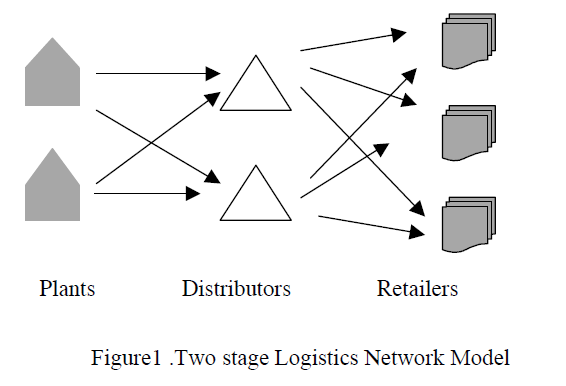


##1.2 Mathematical description

The supply chain logistic network problem is formulated mathematically as a linear
programming model. This model aims to minimize the sum of the costs to transport items from
plants to distributors and from distributors to retailers along with cost of manufacturing.

Indices

*   i Number of Retailers, i ∈ {1,2,…I}
*   j Number of Distribution Centers, j ∈ {1,2,…J}
*   k Number of Plants, k∈ {1,2…K}



Variables


*   X<sub>kj</sub> Quantity that is to be shipped from Plant k to Distributor j
*   Y<sub>ji</sub> Quantity that is to be shipped from Distributor j to Retailer i

Parameters


*   I<sub>d</sub> Demand of Retailers i

*   C<sub>k</sub> Capacity of Plant k
*   C<sub>kj</sub> Unit transportation costs from Plant k to Distributor j

*   W<sub>ji</sub> Unit transportation cost from Distributor j to Retailer i

Constants
*   P<sub>r</sub> Production cost per unit



The objective is to **Minimize**  $$
\sum_{k} \sum_{j} C_{kj} X_{kj} + \sum_{i} \sum_{j} W_{ji} Y_{ji} + P_r\sum_{k} \sum_{j} X_{kj}
$$

Subject to:
• Quantity transported from any plant to all distributor should be less than or equal to the
capacity of that plant and could be given as
$$ \sum_{k} \sum_{j} X_{kj} ≤ C_k ,\quad for\quad all \quad j, k.$$
• The total amount that enter the distributor should leave the distributor
$$ \sum_{k} \sum_{j} X_{kj} - \sum_{i} \sum_{j} Y_{ji} =0 ,\quad for\quad all \quad i, j, k.$$
• Quantity shipped from the distributor to retailer should not be less than the demand of the
retailers and could be given as
$$ \sum_{i} \sum_{j} Y_{ji} ≥ I_d ,\quad for\quad all \quad i, j$$
• All decision variables are non-negative
$$ X_{kj}, Y_{ji} ≥ 0,\quad for\quad all \quad i, j, k.$$

#2. Implementation
## 2.1 Environement Initialisation

In [ ]:
!pip install pulp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import random
import numpy as np
import random
from pulp import *
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt

## 2.2 Genetic Algorithm

###2.2.1 Initialisation of the Population P<sub>0</sub>

The first step in a GA is the initialisation of a population of n chromosomes with random numbers, but still respecting the different constraints of the problem (Capacity and Demand). The integer n should not be less than twice the length of the chromosome, which is (k*j +j*i).

The architecture of a chromosome for 2 plants, 2 distributers and 3 retailers is given in the figure below:


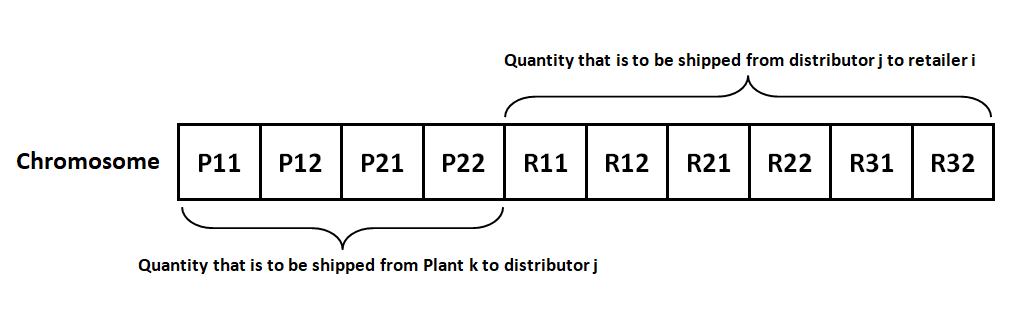




### <center>Figure 2: Coding of a chromosome for a GA</center>

Where

*   P<sub>kj</sub> is the quantity to be shipped from plant k to distributer j
*   R<sub>ji</sub> is the quantity to be shipped from distributer j to retailer i






In [ ]:
# This function generates the first part of a chromosome,Quantity that is to be shipped from Plant k to distributor j.

def genL(k,j,constraint):

  """
  Parameters:
    k number of plants
    j number of distributers
    constraint is a list of capacity constraints for k plants

  """

  L=list()
  const=constraint

  for n in range(k):
    for qte in range(j*n,n*j+j):
      if qte==j*(n+1)-1 :
        L.append(const[n])
      else:
        L.append(random.randint(0,const[n]))
        const[n]-=L[qte]
  return L

In [ ]:
#This function generates the second part of a chromosome, the quantity that is to be shipped from distributor j to retailer i.

def genL2(j,i,constraint):

  """
  Parameters:
    i number of retailers
    j number of distributers
    constraint is a list of demand constraints for i retailers

  """
  L=[0]*(i*j)
  const=constraint


  for n in range(i):
    for qte in range(n,i*j,i):
      if qte>=j*i-i :
        L[qte]=const[n]
      else:
        L[qte]=random.randint(0,const[n])
        const[n]-=L[qte]
  return L

###2.2.2 Verification of the feasability of each chromosome


In [ ]:
def generate(Id,C,i,j,k):

  """
  Parameters:
    i number of retailers
    j number of distributers
    k number of plants
    Id is a list of demand constraints for i retailers
    C is a list of capacity constraints for k plants

  """

  A=np.zeros((i+k+2,i*j+j*k))
  for c1 in range(i):
    for c2 in range(j):
      A[c1][c2+c1*j]=1
  for c2 in range(i*j):
    A[j][c2]=1
    A[j+1][c2]=-1
  for c2 in range(i*j,i*j+j*k):
    A[j][c2]=-1
    A[j+1][c2]=1
  for c1 in range(i+2,i+2+j+1):
    for c2 in range(i*j,i*j+j*k,k):
      A[c1][c2+(c1-i-2)]=-1
  b=np.concatenate((C,np.array([0,0]),-Id))
  return A,b

In [ ]:
def verif(data,Id,C,i,j,k):

  """
  Parameters:
    data is a matrix where each line is a chromosome
    i number of retailers
    j number of distributers
    k number of plants
    Id is a list of demand constraints for i retailers
    C is a list of capacity constraints for k plants

  """

  A,b=generate(Id,C,i,j,k)
  if np.all(np.dot(A, data) <=b):
    return True
  return False



### 2.2.3 Linear Programming

Since the program consists of minimizing a linear function of transport cost, we can solve it using the linear programming method and compare the results of the two methods in the end.

In [ ]:
def pL(Id,C,c,i,j,k): #Programmation lineaire

    """
    Parameters:
      i is the number of retailers
      j is the number of distributers
      k is the number of plants
      Id is a list of demand constraints for i retailers
      C is a list of capacity constraints for k plants
      c is a list of transportation costs

    """
  c=np.array(c)
  A,b=generate(Id,C,i,j,k)
  bounds = [(0, None) for _ in range(c.shape[0])]
  res = linprog(c, A_ub=A, b_ub=b, bounds=bounds)
  return res

### 2.2.4 Fitness function and Selection of parents

The fitness function is minimization of distribution cost and it is
taken directly as fitness values.

In [ ]:
def fitness(x,coef):

  """
  Parameters:
    x is a chromosome
    coef is a list of transportation costs

  """
  return np.dot(x,coef)

Selection procedure provides an opportunity to deliver a gene of a good solution to next generation. We are going to use the **roulette wheel selection** method, considering the solution size and evaluation time.

This method assigns a probability of selection to each individual in a population based on their fitness, and then performs a random selection using a spinning wheel analogy, where individuals with higher fitness have a higher chance of being selected.

Here, the lower the fitness is, the better is the chromosome. So, when calculating the probability, we are going to substruct the fitness of the individual from the maximum obtained value.

For example, considering two chromosomes with respective fitness of 100 and 200. The first chromosome is clearly better. The maximum value here is 200. The adjusted fitness values are now respectivly 100 and 0. The probability to select the first individual is 1 ( \frac{100}{100+0} ) and to select the second is 0.

In [ ]:
def Selection(data):

  """
  Parameters:
    data is a matrix where each line is a chromosome

  """
  p=list()
  S=0
  for x in data :
    S+=fitness(x,coef)
    p.append(fitness(x,coef))
  mx=max(p)
  adjusted_fitness_values = [mx - f+1 for f in p]
  # compute the probabilities of selection for each individual
  total_adjusted_fitness = sum(adjusted_fitness_values)
  p = [f / total_adjusted_fitness for f in adjusted_fitness_values]

  r=random.random()
  partialsum=0
  for i in range(len(p)):
    partialsum+=p[i]
    if(partialsum>=r):
      return data[i,:]  #return the chromosome x in the position i

### 2.2.5 Crossover

Crossover involves combining genetic information from two parent individuals to create offspring. It mimics the process of genetic recombination in nature, where portions of the parent chromosomes are exchanged to create new genetic combinations.

This operation has a probability P<sub>c</sub> normally ranging between 0.6 and 0.9.

The choice of the two parents is given by the previous step of selection based on their fitness. The Crossover in this project will be on a single crossover point, which is shown in this figure:

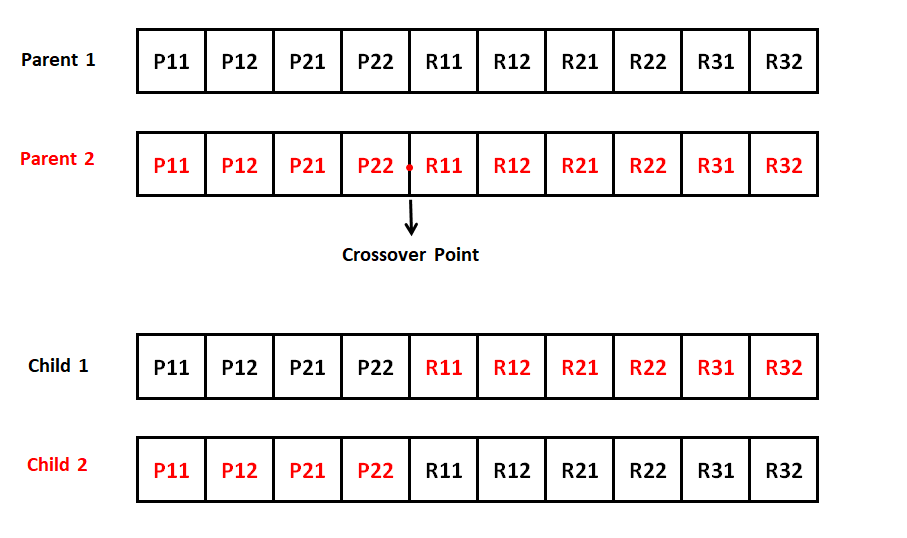

### <center>Figure 3: Crossover Process example</center>

In [ ]:
#This crossover function is based on one crossover point
def crossover(parent1,parent2,i,j):

  """
  Parameters:
    parent1,parent2 are the selected chromosomes having the best fitness
    i can be the number of retailers or plants
    j number of distributers

  """
  pc=random.uniform(0.6,0.9)
  if random.random()>pc:
    return parent1, parent2
  crossover_point = i*j
  parent1=list(parent1)
  parent2=list(parent2)
  child1 = parent1[:crossover_point] + parent2[crossover_point:]
  child2 = parent2[:crossover_point] + parent1[crossover_point:]
  child1,child2=np.array(child1),np.array(child2)
  return child1, child2


### 2.2.6 Mutation

Mutation is a genetic operator that introduces small, random changes in the genetic material of an individual. It helps to maintain diversity in the population and enables the exploration of new areas in the search space, potentially leading to improved solutions.

The mutation has a very low probability P<sub>m</sub> which is a random number between 0.001 and 0.01.

The process of mutation is shown in the next figure. Note that the swap of the values in the chromosome should be in feasable positions.

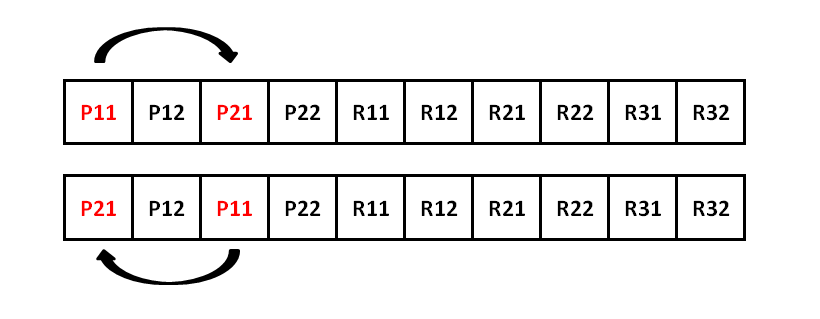

### <center>Figure 4: Mutation Process Example</center>

In [ ]:
#This function returns a chromosome after the mutation

def mutate(x,k,j,i):

  """
  Parameters:
    x is a chromosome
    i number of retailers
    j number of distributers
    k number of plants

  """
  pm=random.uniform(0.001,0.01)
  if random.random()>pm:
    return x
  mutation_index=random.randint(0,9)
  if mutation_index< j:
    x[mutation_index+j],x[mutation_index]=x[mutation_index],x[mutation_index+j] #permutation in feasable position
  elif j<=mutation_index< k*j:
    x[mutation_index-j],x[mutation_index]=x[mutation_index],x[mutation_index-j] #permutation
  elif mutation_index <=i*j:

    x[mutation_index+i],x[mutation_index]=x[mutation_index],x[mutation_index+i] #permutation

  else:

    x[mutation_index-i],x[mutation_index]=x[mutation_index],x[mutation_index-i] #permutation
  return x


After the mutation, whether it happened or not, we have to insert the new children in the previous population, making sure to keep the same initial number of chromosomes in the population.

In [ ]:
def insert(P1,P2,child1,child2,data,Id,C,k,j,i,coef):

  """
  Parameters:
    parent1,parent2 are the parents chromosomes having the best fitness
    child1,child2 are the children chromosomes
    i is the number of retailers
    j is the number of distributers
    k is the number of plants
    Id is a list of demand constraints for i retailers
    C is a list of capacity constraints for k plants
    coef is a list of transportation costs
    data is a matrix where each line is a chromosome

   """

  if (verif(child1,Id,C,k,j,i)==True and fitness(P1,coef)>=fitness(child1,coef)):
    data=np.vstack((data,child1))

  if (verif(child2,Id,C,k,j,i)==True and fitness(P2,coef)>=fitness(child2,coef)):
    data=np.vstack((data,child2))

  return data


#3. Numerical Illustration and Results

Now, we are going to test the whole algorithm on the same previous example consisiting of 2 plants, 2 distributers and 3 retailers. The capacity constraints of the two plants is [150000,150000] , and the demand constraints for the retailers is [50000,100000,50000].

The number of generations is considered as a termination criterion
in this application and the user could vary it. The program is made to run till the number of iteration becomes equal to the present maximum number as termination criteria (Nchr).

In [ ]:
#Initial population

data=np.empty((0,10))
L=[]
C=np.array([150000,50000])
Id=np.array([50000,100000,50000])
k=2 # nbr of plants
j=2 # nbr of distributers
i=3 # nbr of retailers
Nchr=1000 # Normally Nchr should be no less than 2*(k*j+j*i +1)
nbrmax=1000
while True:
  while True:
    data1=np.concatenate((genL(k,j,C),genL2(j,i,Id)))
    C=np.array([150000,50000])
    Id=np.array([50000,100000,50000])
    if verif(data1,Id,C,k,j,i)==True:
      break
  data=np.vstack((data,data1))
  data=np.unique(data,axis=0)
  if data.shape[0]==Nchr:
    break

compteur=0
coef=np.array([0,5,4,2,3,4,5,2,1,2])
# data=np.vstack((np.array([150000.,      0.,      0.,  50000.,      0.,      0.,      0.,
#          50000., 100000.,  50000.]),data))

# data=np.vstack((data,np.array([[0 ,0, 50000 ,150000 ,0 ,0 ,50000 ,50000 ,100000 ,0],[
# 50000 ,150000 ,0 ,0 ,19169 ,15724 ,15107 ,30831 ,84276 ,34893 ],[
# 50000 ,150000 ,0 ,0 ,26962 ,1426 ,21612 ,23038 ,98574 ,28388 ],[
# 0, 0 ,50000 ,150000 ,0, 0 ,50000 ,50000 ,100000 ,0 ],[
# 0, 0 ,50000 ,150000 ,0, 0, 50000, 50000 ,100000 ,0 ],[
# 0 ,0, 50000, 150000, 0 ,0 ,50000, 50000, 100000 ,0 ],[
# 0, 0, 50000 ,150000, 4827 ,5436 ,39737 ,45173 ,94564 ,10263 ],[
# 0 ,0 ,50000 ,150000 ,3902 ,153, 45945 ,46098 ,99847 ,4055 ],[
# 50000, 150000, 0, 0, 17421 ,18716, 13863 ,32579 ,81284 ,36137 ],[
# 50000 ,150000, 0, 0, 0, 0, 50000 ,50000 ,100000 ,0 ] ]

#  )))

while True:
  compteur+=1

  #Perform the selection of the 2 parents
  P1=Selection(data)
  while True:
    P2=Selection(data)
    if np.all(P2!=P1):
      break


  #Getting the new children
  child1,child2=crossover(P1,P2,k,j)
  child1=mutate(child1,k,j,i)
  child2=mutate(child2,k,j,i)

  data=insert(P1,P2,child1,child2,data,Id,C,k,j,i,coef)     #Inserting the child into the new population
  data=np.unique(data,axis=0)

  f_values = [fitness(row, coef) for row in data]           #Evaluating the fitness of each chromosome in order to sort the data

  sorted_indices = np.argsort(f_values)
  sorted_data = data[sorted_indices]
  data=sorted_data[:Nchr,:]

  L.append(fitness(data[0,:],coef))

  if compteur>=nbrmax:
    break
data[0,:]

array([149743.,    257.,   1253.,  48747.,  18490.,   4245.,   2774.,
        31510.,  95755.,  47226.])

In [ ]:
s=pL(Id,C,coef,k,j,i)
s.x

array([150000.,      0.,      0.,  50000.,      0.,      0.,      0.,
        50000., 100000.,  50000.])

As we can see here, the two results of the GA and the Linear Programming are very close. The reason why we don't reach the exact solution is due to the random generation of the population.

In [ ]:
s.fun

400000.0

In [ ]:
fitness(data[0,:],coef)

443338.0

As for the minimum cost found by our GA, we can see that it is also very close to the exact solution.

In [ ]:
data

array([[149743.,    257.,   1253., ...,  31510.,  95755.,  47226.],
       [149743.,    257.,   1253., ...,  29600.,  94748.,  47172.],
       [146282.,   3718.,   4183., ...,  37104.,  95427.,  49928.],
       ...,
       [ 95848.,  54152.,  37280., ...,  20746.,  69998.,  21514.],
       [125152.,  24848.,  47045., ...,  37036.,   2440.,  41203.],
       [107023.,  42977.,    862., ...,  47707.,   7854.,  31615.]])

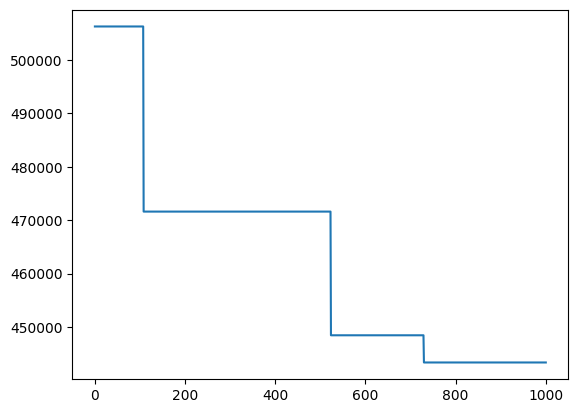

In [ ]:
t=np.linspace(0,compteur,compteur)
plt.plot(t,L)
plt.show()

This figure above shows the value of the fitness decreasing by the number of iterations.

#Conclusion

In conclusion, this project has demonstrated the effectiveness of using Genetic Algorithms to solve  a two-echelon supply chain optimization problem. Additionally, this project has demonstrated the efficiency of Genetic Algorithms even when the numbers of plants, distributors, and retailers are increased. Given the algorithm's efficiency in these contexts, it holds promising potential for tackling even more complex challenges like Multi-echelon supply chains.
